In [1]:
import pathlib
import pickle

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import cartopy
import cartopy.crs as ccrs
import cmasher as cmr
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
import galstreams
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import median_absolute_deviation as MAD
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from ezpadova import parsec
from gala.units import galactic
from pyia import GaiaData
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import minimize
from tqdm.auto import tqdm
import skyproj
import healpy as hp

from helpers import get_isochrone

%matplotlib inline

In [2]:
mwstreams = galstreams.MWStreams()

Initializing galstreams library from master_log... 


In [3]:
iso = get_isochrone()

tmp_iso = iso[iso["stage"] == 1]
MSTO_absmag = tmp_iso["rP1"].min()

## Load data table, compiled in `Stream-data.ipynb`

In [4]:
with open("../data/all_stream_summary_data.pkl", "rb") as f:
    data = pickle.load(f)

data["length"] = [x.phi1.max() - x.phi1.min() for x in data["track"]]
data["r_mag"] = [MSTO_absmag + np.mean(x.distance.distmod.value) for x in data["track"]]

In [6]:
(data["discovery_method"] == "photometry").sum(), len(data)

(48, 129)

In [5]:
post_gaia = data[
    np.isin(data["discovery_method"], ["astrometry", "iom-clustering", "streamfinder"])
]
pre_gaia = data[np.isin(data["discovery_method"], ["photometry", "rrl"])]
assert len(pre_gaia) + len(post_gaia) == len(data)

In [6]:
pre_gaia_colors = cmr.get_sub_cmap("cmr.infinity", 0.0, 0.5, N=len(pre_gaia)).colors
other_colors = cmr.get_sub_cmap("cmr.infinity", 0.5, 1.0, N=len(post_gaia)).colors

Estimate a more realistic spectroscopic limit, based on:
https://www.lco.cl/technical-documentation/the-mike-magellan-inamori-kyocera-echelle-users-guide/

In [7]:
V = 17.0
SNR = 50
R = 30_000
ref_lambda = 5500 * u.angstrom

req = SNR**2 * u.electron / u.pixel
num1 = (
    1.0
    * u.electron
    / u.second
    / u.Angstrom
    * ref_lambda
    / R
    / u.pixel
    * 10 ** (0.4 * (18.4 - V))
    * 0.7
)
(req / num1).to(u.hour)

<Quantity 1.4903835 h>

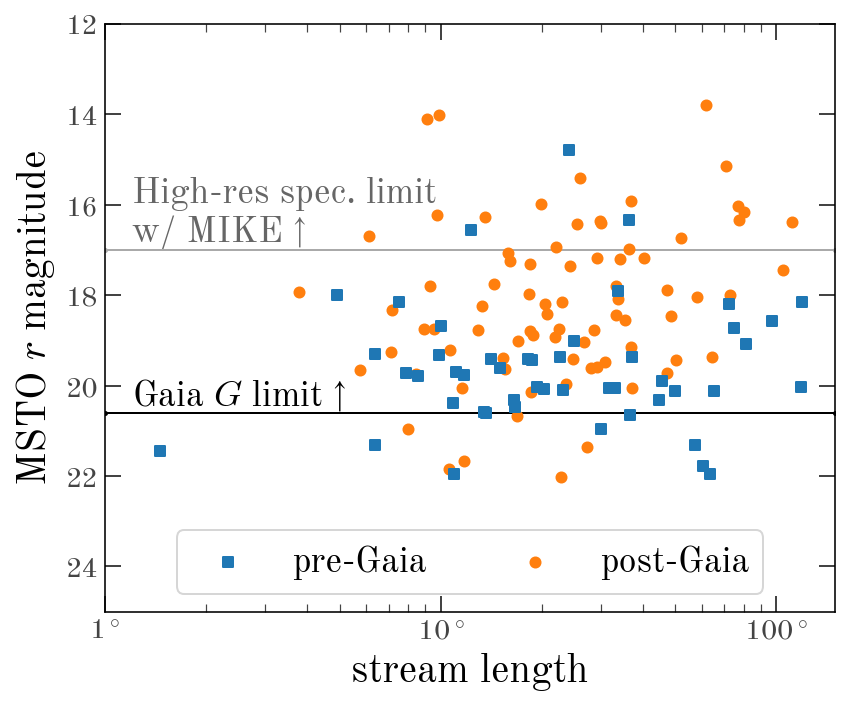

In [8]:
pre_gaia_color = "tab:blue"
pre_gaia_marker = "s"
post_gaia_color = "tab:orange"
post_gaia_marker = "o"


fig, ax = plt.subplots(1, 1, figsize=(6, 5), layout="tight")

ax.scatter(
    pre_gaia["length"],
    pre_gaia["r_mag"],
    label="pre-Gaia",
    c=pre_gaia_color,
    marker=pre_gaia_marker,
    zorder=100,
)
ax.scatter(
    post_gaia["length"],
    post_gaia["r_mag"],
    label="post-Gaia",
    c=post_gaia_color,
    marker=post_gaia_marker,
    zorder=10,
)
ax.legend(loc="lower center", ncols=2, fontsize=18)

ax.set(
    xscale="log",
    xlim=(1, 150),
    ylim=(25, 12),
    xticks=[1, 10, 100],
    xticklabels=[r"1$^\circ$", r"10$^\circ$", r"100$^\circ$"],
)


# ax.axhspan(20.6, max(ax.get_ylim()), linewidth=0, zorder=-100, color='#dddddd')
ax.axhline(20.6, linewidth=1, zorder=-100, color="k")
ax.axhline(V, linewidth=1, zorder=-100, color="#aaaaaa", linestyle="-")

ax.text(
    ax.get_xlim()[0] + 0.2,
    20.6,
    "Gaia $G$ limit ↑",
    ha="left",
    va="bottom",
    fontsize=18,
    color="k",
)

ax.text(
    ax.get_xlim()[0] + 0.2,
    V,
    "High-res spec. limit \nw/ MIKE ↑",
    ha="left",
    va="bottom",
    fontsize=18,
    color="#666666",
)

# ax.set_title("Pre-Gaia Streams")
# ax.set_title("Streams Discovered with Gaia")
ax.set_xlabel(r"stream length")
ax.set_ylabel("MSTO $r$ magnitude")

fig.savefig("../tex/figures/msto-rc-mag.pdf")

Text(0, 0.5, 'rough total stellar mass')

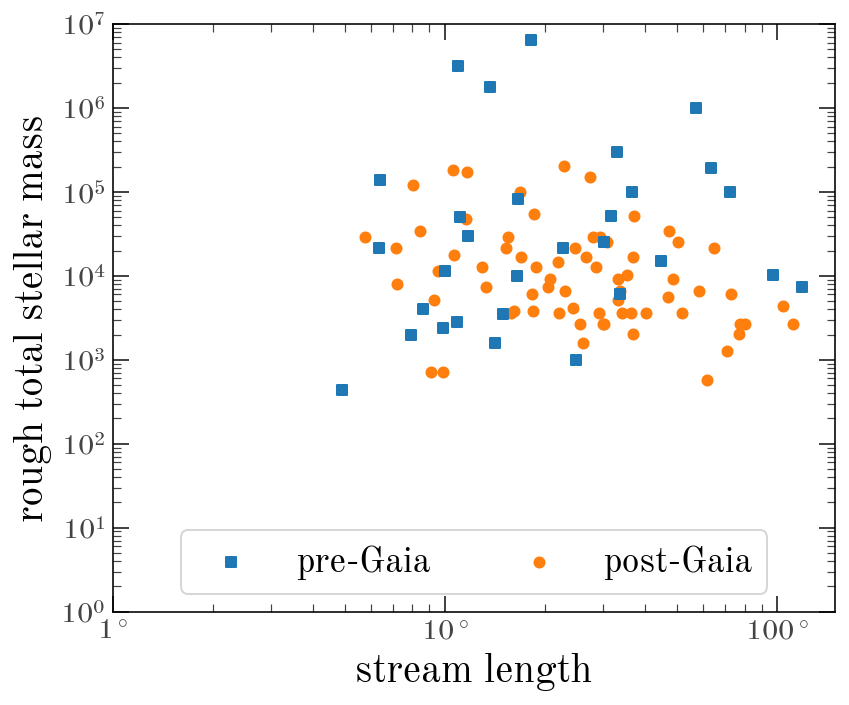

In [9]:
pre_gaia_color = "tab:blue"
pre_gaia_marker = "s"
post_gaia_color = "tab:orange"
post_gaia_marker = "o"


fig, ax = plt.subplots(1, 1, figsize=(6, 5), layout="tight")

ax.scatter(
    pre_gaia["length"],
    pre_gaia["stellar_mass"],
    label="pre-Gaia",
    c=pre_gaia_color,
    marker=pre_gaia_marker,
    zorder=100,
)

ax.scatter(
    post_gaia["length"],
    post_gaia["stellar_mass"],
    label="post-Gaia",
    c=post_gaia_color,
    marker=post_gaia_marker,
    zorder=10,
)
ax.legend(loc="lower center", ncols=2, fontsize=18)

ax.set(
    xscale="log",
    yscale="log",
    xlim=(1, 150),
    ylim=(1, 1e7),
    xticks=[1, 10, 100],
    xticklabels=[r"1$^\circ$", r"10$^\circ$", r"100$^\circ$"],
)

# ax.set_title("Pre-Gaia Streams")
# ax.set_title("Streams Discovered with Gaia")
ax.set_xlabel(r"stream length")
ax.set_ylabel("rough total stellar mass")

---

## Sky plot

Plot the sky tracks of all streams - Ibata and S5 streams get color, other galstreams streams gray.

In [10]:
order = 8
hpx = at.Table.read("../data/healpix_8-result.fits.gz")
assert hp.order2npix(order) == len(hpx)

hpx_map = np.full(hp.order2npix(order), np.nan)
hpx_map[hpx["healpix"]] = hpx["N"]

# # hpx_map[hpx['healpix_6']] = np.log(hpx['sum_bp'] / hpx['sum_rp'])
# hp.mollview(
#     hpx_map,
#     nest=True,
#     cmap="Greys_r",
#     rot=[266.40498829, -28.93617776, 59.0],
#     norm=mpl.colors.LogNorm(1e2, 1e4),
# )

In [11]:
ipix = hp.ring2nest(hp.order2nside(order), np.arange(len(hpx_map)))
hpx_map_ring = hpx_map[ipix]

# Rotate to galactic:
rot = hp.Rotator(rot=[266.40498829, -28.93617776, 59.0])
gal_hpx_map = rot.rotate_map_pixel(hpx_map_ring)

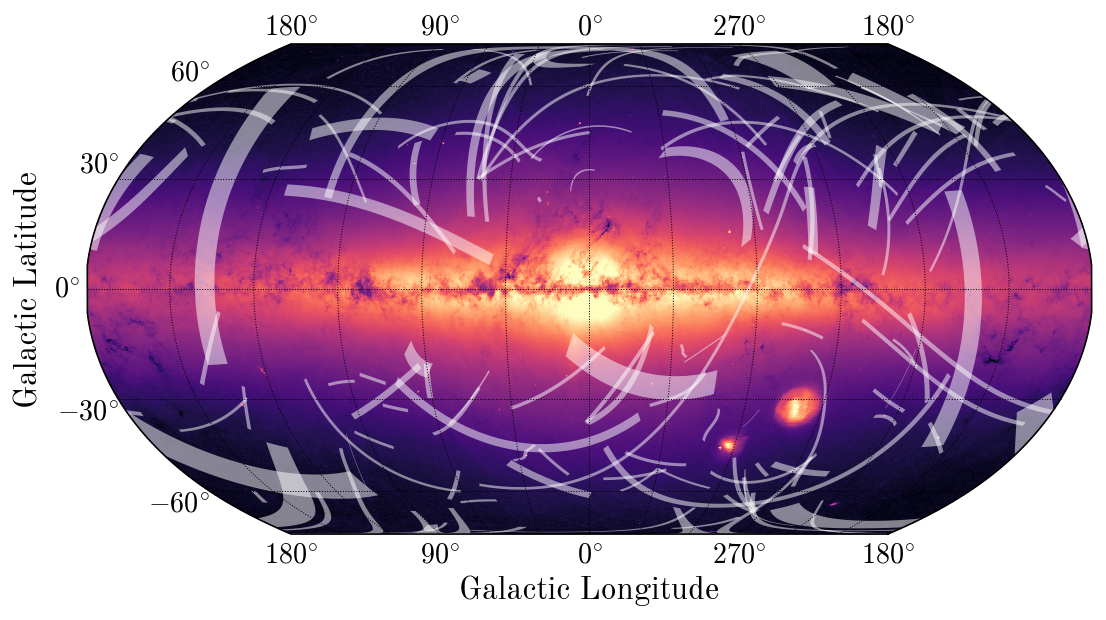

In [30]:
fig, ax = plt.subplots(figsize=(9, 5), layout="constrained")
proj = skyproj.EqualEarthSkyproj(ax=ax, galactic=True)
proj.draw_hpxmap(np.log(gal_hpx_map), vmin=np.log(1e2), vmax=np.log(5e4))
for row in data:
    track = coord.SkyCoord(
        row["sky_poly"].data.without_differentials(),
        frame=row["sky_poly"].frame.replicate_without_data(),
    )
    proj.draw_polygon(
        track.galactic.l.wrap_at(180 * u.deg).degree,
        track.galactic.b.degree,
        facecolor="w",
        edgecolor="none",
        linewidth=0,
        alpha=0.5,
        rasterized=True
    )

fig.savefig("../tex/figures/stream-sky-map.pdf", dpi=200)